In [ ]:

import os
import numpy as np
import tensorflow as tf
import pandas as pd
import sentencepiece as spm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from konlpy.tag import Mecab
from konlpy.tag import Mecab, Okt


mecab = Mecab()  


# 데이터 경로 
data_dir = os.path.expanduser('~/aiffel/sentiment_classification/data/')
train_file = os.path.join(data_dir, 'ratings_train2.txt')
test_file  = os.path.join(data_dir, 'ratings_test2.txt')


In [ ]:
def data_eda(file_path):
    df = pd.read_csv(file_path, sep="\t").dropna()
    print(f"\n[EDA for {file_path}]")
    print("데이터 개수:", len(df))
    print("라벨 분포:")
    print(df['label'].value_counts())
    
    # 문장 길이 통계
    df['length'] = df['document'].apply(lambda x: len(str(x)))
    print("문장 길이 통계:")
    print(df['length'].describe(), '\n')
    
    return df

In [2]:
def preprocess_text(df):
    """
    불필요한 문자 제거 등 기본 전처리.
    """
    df['document'] = df['document'].astype(str).str.strip()
    # 특수문자, 이모티콘 제거, 한글/숫자/알파벳/공백만 남김
    df['document'] = df['document'].str.replace(r"[^가-힣0-9a-zA-Z\s]", "", regex=True)
    return df

In [5]:
# Step 1. 네이버 영화리뷰 데이터 로드 + EDA + 전처리
# 1-1) EDA 진행
df_train = eda(train_file)
df_test  = eda(test_file)

# 1-2) 텍스트 전처리
df_train = preprocess_text(df_train)
df_test  = preprocess_text(df_test)

# 1-3) 결측 제거 (전처리 후 생길 수 있는 결측 포함)
df_train.dropna(subset=['document'], inplace=True)
df_test.dropna(subset=['document'], inplace=True)

# 1-4) numpy array 형태로 변환
train_reviews = df_train['document'].values
train_labels = df_train['label'].values
test_reviews = df_test['document'].values
test_labels = df_test['label'].values

print("훈련용 리뷰 개수:", len(train_reviews))
print("테스트용 리뷰 개수:", len(test_reviews))



[EDA for /aiffel/aiffel/sentiment_classification/data/ratings_train2.txt]
데이터 개수: 149995
라벨 분포:
0    75170
1    74825
Name: label, dtype: int64
문장 길이 통계:
count    149995.000000
mean         35.204527
std          29.531890
min           1.000000
25%          16.000000
50%          27.000000
75%          42.000000
max         146.000000
Name: length, dtype: float64 


[EDA for /aiffel/aiffel/sentiment_classification/data/ratings_test2.txt]
데이터 개수: 49997
라벨 분포:
1    25171
0    24826
Name: label, dtype: int64
문장 길이 통계:
count    49997.000000
mean        35.320259
std         29.648310
min          1.000000
25%         16.000000
50%         27.000000
75%         43.000000
max        144.000000
Name: length, dtype: float64 

훈련용 리뷰 개수: 149995
테스트용 리뷰 개수: 49997


In [6]:
# Step 2. SentencePiece 모델 학습 (korean_spm2 모델)
temp_sp_file = os.path.join(data_dir, 'review_train.temp')
with open(temp_sp_file, 'w', encoding='utf-8') as f:
    for review in train_reviews:
        f.write(review + '\n')

# SentencePiece 학습 파라미터 설정
sp_vocab_size = 5000
sp_model_prefix = os.path.join(data_dir, 'korean_spm2')  # 모델 파일 접두어
sp_model_type = 'unigram'  # unigram, bpe 등 가능

# SentencePiece 모델 학습
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix={} --vocab_size={} --model_type={}'.format(
        temp_sp_file, sp_model_prefix, sp_vocab_size, sp_model_type
    )
)

# 모델 파일 확인
print("\n[SentencePiece 모델 파일 확인]")
get_ipython().system(f"ls -l {sp_model_prefix}*")


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sentiment_classification/data/review_train.temp --model_prefix=/aiffel/aiffel/sentiment_classification/data/korean_spm2 --vocab_size=20000 --model_type=unigram
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sentiment_classification/data/review_train.temp
  input_format: 
  model_prefix: /aiffel/aiffel/sentiment_classification/data/korean_spm2
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabular


[SentencePiece 모델 파일 확인]
-rw-r--r-- 1 root root 618249 Feb 25 06:26 /aiffel/aiffel/sentiment_classification/data/korean_spm2.model
-rw-r--r-- 1 root root 398386 Feb 25 06:26 /aiffel/aiffel/sentiment_classification/data/korean_spm2.vocab


In [7]:
# Step 3. sp_tokenize() 함수 구현
def sp_tokenize(sp_model, corpus):
    tensor = []
    for sen in corpus:
        tensor.append(sp_model.EncodeAsIds(sen))
    
    vocab_path = sp_model_prefix + '.vocab'
    with open(vocab_path, 'r', encoding='utf-8') as f:
        vocab_lines = f.readlines()
    
    word_index = {}
    index_word = {}
    for idx, line in enumerate(vocab_lines):
        token = line.split("\t")[0]
        word_index[token] = idx
        index_word[idx] = token

    tensor = pad_sequences(tensor, padding='post')
    return tensor, word_index, index_word

In [8]:
# Step 4. SentencePiece 토크나이저 적용 및 데이터 전처리
sp_processor = spm.SentencePieceProcessor()
sp_processor.Load(sp_model_prefix + '.model')

train_tensor_sp, sp_word_index, sp_index_word = sp_tokenize(sp_processor, train_reviews)
test_tensor_sp, _, _ = sp_tokenize(sp_processor, test_reviews)
vocab_size_sp = len(sp_word_index)
print("\n[SentencePiece (unigram)] Vocab Size:", vocab_size_sp)


# Step 5. RNN 모델 (LSTM) 구성 및 학습 (SentencePiece)

embedding_dim = 128
max_length_sp = train_tensor_sp.shape[1]

model_sp_improved = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size_sp, embedding_dim, input_length=max_length_sp),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_sp_improved.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model_sp_improved.summary()

history_improved = model_sp_improved.fit(
    train_tensor_sp, train_labels,
    epochs=15,
    batch_size=256,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=3, restore_best_weights=True
    )]
)

test_loss_improved, test_acc_improved = model_sp_improved.evaluate(test_tensor_sp, test_labels)
print(f"[Improved SentencePiece Model] Test Accuracy: {test_acc_improved:.4f}")

# 상위 50개 단어 출력
print("\n=== SentencePiece 단어 사전 (일부) ===")
for idx, (token, index) in enumerate(sp_word_index.items()):
    print(f"{index}: {token}")
    if idx >= 50:  # 50개까지만 출력
        break


[SentencePiece (unigram)] Vocab Size: 20000
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 128)          2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 128)          98816     
_________________________________________________________________
dropout (Dropout)            (None, 104, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (De

In [9]:
#SentencePiece 토크나이저 사용 예시
s = spm.SentencePieceProcessor()
s.Load(sp_model_prefix + '.model')

sample_sentence = "이 영화는 정말 감동적이었어요."
tokens_ids = s.EncodeAsIds(sample_sentence)
tokens_pieces = s.EncodeAsPieces(sample_sentence)
decoded_sentence = s.DecodeIds(tokens_ids)

print(f"\n[SAMPLE SentencePiece Usage]")
print(f"Original Sentence: {sample_sentence}")
print(f"Tokenized IDs: {tokens_ids}")
print(f"Tokenized Pieces: {tokens_pieces}")
print(f"Decoded Sentence: {decoded_sentence}")


[SAMPLE SentencePiece Usage]
Original Sentence: 이 영화는 정말 감동적이었어요.
Tokenized IDs: [19, 70, 16, 11747, 0]
Tokenized Pieces: ['▁이', '▁영화는', '▁정말', '▁감동적이었어요', '.']
Decoded Sentence: 이 영화는 정말 감동적이었어요 ⁇ 


In [13]:
# Step 6. Mecab 형태소 분석 전처리 & 모델 학습 (비교)
def mecab_tokenize(corpus):
    tokenized = []
    for sen in corpus:
        tokenized.append(mecab.morphs(sen))
    return tokenized

train_tokens_mecab = mecab_tokenize(train_reviews)
test_tokens_mecab  = mecab_tokenize(test_reviews)

tokenizer_mecab = Tokenizer(filters='')
tokenizer_mecab.fit_on_texts(train_tokens_mecab)

train_seq_mecab = tokenizer_mecab.texts_to_sequences(train_tokens_mecab)
test_seq_mecab  = tokenizer_mecab.texts_to_sequences(test_tokens_mecab)

max_length_mecab = max(len(seq) for seq in train_seq_mecab)
train_seq_mecab = pad_sequences(train_seq_mecab, maxlen=max_length_mecab, padding='post')
test_seq_mecab  = pad_sequences(test_seq_mecab, maxlen=max_length_mecab, padding='post')

vocab_size_mecab = len(tokenizer_mecab.word_index) + 1
print(f"\n[Mecab] Vocab Size: {vocab_size_mecab}")

model_mecab = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size_sp, embedding_dim, input_length=max_length_sp),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_mecab.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_mecab.summary()

history_mecab = model_mecab.fit(
    train_seq_mecab, train_labels,
    epochs=5,
    batch_size=256,
    validation_split=0.2
)
test_loss_mecab, test_acc_mecab = model_mecab.evaluate(test_seq_mecab, test_labels)
print(f"[Mecab] Test Accuracy: {test_acc_mecab:.4f}")


[Mecab] Vocab Size: 50676
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 104, 128)          2560000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 104, 128)          98816     
_________________________________________________________________
dropout_2 (Dropout)          (None, 104, 128)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)            

In [14]:


# 최소한의 레이어를 사용한 모델 비교

def build_minimal_model(vocab_size, input_length, embedding_dim=128):
    """
    Embedding + LSTM(64) + Dense(1) 만 사용한 최소 구조
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=input_length),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

print("\n[비교] 최소 레이어 모델로 Mecab vs SentencePiece 비교")

# Mecab 최소 레이어
model_mecab_min = build_minimal_model(
    vocab_size=vocab_size_mecab,
    input_length=max_length_mecab,
    embedding_dim=128
)

history_mecab_min = model_mecab_min.fit(
    train_seq_mecab, train_labels,
    epochs=3,
    batch_size=256,
    validation_split=0.2
)
test_loss_mecab_min, test_acc_mecab_min = model_mecab_min.evaluate(test_seq_mecab, test_labels)
print(f"[Mecab + Minimum Model] Test Accuracy: {test_acc_mecab_min:.4f}")

# SentencePiece 최소 레이어
model_sp_min = build_minimal_model(
    vocab_size=vocab_size_sp,
    input_length=max_length_sp,
    embedding_dim=128
)

history_sp_min = model_sp_min.fit(
    train_tensor_sp, train_labels,
    epochs=3,
    batch_size=256,
    validation_split=0.2
)
test_loss_sp_min, test_acc_sp_min = model_sp_min.evaluate(test_tensor_sp, test_labels)
print(f"[SentencePiece + Minimum Model] Test Accuracy: {test_acc_sp_min:.4f}")


[비교] 최소 레이어 모델로 Mecab vs SentencePiece 비교
Epoch 1/3
469/469 [==============================] - 7s 12ms/step - loss: 0.6933 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.4973
Epoch 2/3
469/469 [==============================] - 5s 11ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6935 - val_accuracy: 0.4973
Epoch 3/3
1563/1563 [==============================] - 4s 3ms/step - loss: 0.6933 - accuracy: 0.4965
[Mecab + Minimum Model] Test Accuracy: 0.4965
Epoch 1/3
469/469 [==============================] - 6s 10ms/step - loss: 0.6933 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.5027
Epoch 2/3
469/469 [==============================] - 5s 10ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5027
Epoch 3/3
1563/1563 [==============================] - 5s 3ms/step - loss: 0.6931 - accuracy: 0.5035
[SentencePiece + Minimum Model] Test Accuracy: 0.5035


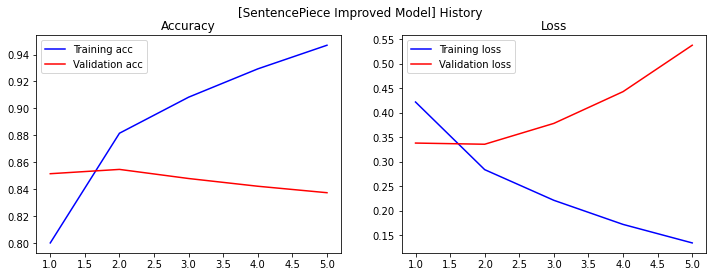

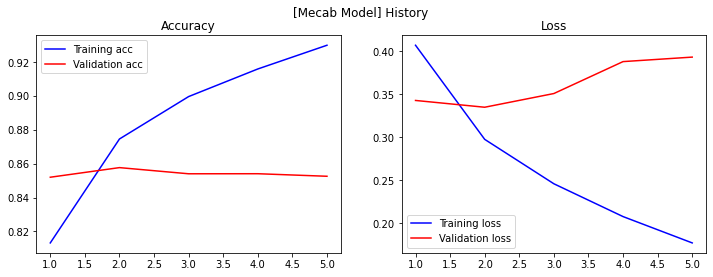

In [16]:
# 학습 과정 시각화 (정확도 & 손실 그래프)
def plot_training_history(history, title="Training History"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))
    plt.suptitle(title)
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Accuracy')
    plt.legend()
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

# 시각화 (예시: SentencePiece Improved 모델 + Mecab 모델)
plot_training_history(history_improved, "[SentencePiece Improved Model] History")
plot_training_history(history_mecab, "[Mecab Model] History")


In [17]:

# 모델 예측 확인

print("\n[모델 예측 샘플]")

# 1) SentencePiece 샘플 문장 토큰화 확인
sample_texts = df_test['document'].sample(3).tolist()
for text in sample_texts:
    print(f"Original: {text}")
    print(f"Tokenized Pieces: {sp_processor.EncodeAsPieces(text)}")
    print(f"Tokenized IDs: {sp_processor.EncodeAsIds(text)}")
    print("-" * 50)

# 2) 임의 예측 결과 확인
X_final_test = test_tensor_sp  # SentencePiece 시퀀스
y_final_test = test_labels

sample_a = np.random.choice(len(X_final_test), 5, replace=False)
for idx in sample_a:
    pred = model_sp_improved.predict(X_final_test[idx].reshape(1, -1))
    label = y_final_test[idx]
    doc_text = df_test.iloc[idx]['document']
    print(f"Sentence: {doc_text}")
    print(f"Predicted Probability: {pred[0][0]:.4f}")
    predicted_label = "Positive" if pred[0][0] > 0.5 else "Negative"
    actual_label = "Positive" if label == 1 else "Negative"
    print(f"--> Predicted: {predicted_label} / Actual: {actual_label}")
    print("-" * 50)


[모델 예측 샘플]
Original: 솔직히이건아니지 따라한것도 따라한건데 내용도 쓰레기네 
Tokenized Pieces: ['▁솔직히', '이건', '아니', '지', '▁따라한', '것도', '▁따라한', '건데', '▁내용도', '▁쓰레기네']
Tokenized IDs: [206, 907, 1068, 18, 8155, 695, 8155, 1431, 349, 7885]
--------------------------------------------------
Original: 영화관에 단 두명 그러나 영화는 최고 유쾌한 웃음
Tokenized Pieces: ['▁영화관에', '▁단', '▁두명', '▁그러나', '▁영화는', '▁최고', '▁유쾌한', '▁웃음']
Tokenized IDs: [9235, 773, 6451, 978, 70, 86, 1661, 1666]
--------------------------------------------------
Original: 백수  옛다 3점
Tokenized Pieces: ['▁백', '수', '▁옛다', '▁3', '점']
Tokenized IDs: [1228, 89, 9012, 93, 27]
--------------------------------------------------
Sentence: 생각외로 빼어난 구성충분한 재미
Predicted Probability: 0.8255
--> Predicted: Positive / Actual: Positive
--------------------------------------------------
Sentence: 고급지다월메이드 무비
Predicted Probability: 0.8149
--> Predicted: Positive / Actual: Positive
--------------------------------------------------
Sentence: 재미잇음
Predicted Probability: 0.9350
--> Predi

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import sentencepiece as spm
import tensorflow as tf
from konlpy.tag import Mecab, Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



def sample_subset(train_reviews, train_labels, ratio=0.3):
    """
    train_reviews, train_labels 중 일부(ratio 비율)를 무작위 추출하여 반환.
    """
    total_size = len(train_reviews)
    subset_size = int(total_size * ratio)

    indices = list(range(total_size))
    random.shuffle(indices)
    subset_indices = indices[:subset_size]

    train_reviews_subset = [train_reviews[i] for i in subset_indices]
    train_labels_subset  = np.array([train_labels[i] for i in subset_indices])

    return train_reviews_subset, train_labels_subset



def tokenize_mecab(corpus):
    m = Mecab()
    tokenized = []
    for sen in corpus:
        tokenized.append(m.morphs(sen))
    return tokenized

def tokenize_okt(corpus):
    o = Okt()
    tokenized = []
    for sen in corpus:
        tokenized.append(o.morphs(sen))
    return tokenized

def tokenize_sentencepiece(corpus, model_prefix, model_type='unigram', vocab_size=8000):
    temp_input_file = model_prefix + "_tempinput.txt"
    with open(temp_input_file, 'w', encoding='utf-8') as f:
        for line in corpus:
            f.write(line.strip() + "\n")

    spm_cmd = f"--input={temp_input_file} --model_prefix={model_prefix} --vocab_size={vocab_size} --model_type={model_type}"
    spm.SentencePieceTrainer.Train(spm_cmd)

    sp = spm.SentencePieceProcessor()
    sp.Load(model_prefix + '.model')

    sequences = []
    for sen in corpus:
        sequences.append(sp.EncodeAsIds(sen))

    with open(model_prefix + '.vocab', 'r', encoding='utf-8') as vf:
        vocab_lines = vf.readlines()
    sp_vocab_size = len(vocab_lines)

    os.remove(temp_input_file)
    return sequences, sp_vocab_size

def tokenize_and_convert_keras(corpus_tokenized):
    tokenizer = Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus_tokenized)
    sequences = tokenizer.texts_to_sequences(corpus_tokenized)
    vocab_size = len(tokenizer.word_index) + 1
    return sequences, vocab_size

def build_minimal_model(vocab_size, input_length, embedding_dim=128):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=input_length),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def train_tokenizer_and_evaluate(
    tokenizer_name,
    train_reviews,
    test_reviews,
    train_labels,
    test_labels,
    epochs=3,
    model_type=None,
    vocab_size=8000,
):
    """
    주어진 tokenizer_name에 따라 토큰화+학습 후 (loss, acc) 반환
    - 'mecab', 'okt'
    - 'sentencepiece' (model_type: 'unigram'/'bpe'/'word'/'char')
    """

    if tokenizer_name in ['mecab', 'okt']:
        if tokenizer_name == 'mecab':
            tokenized = tokenize_mecab(train_reviews)
            tokenized_test = tokenize_mecab(test_reviews)
        else:  # okt
            tokenized = tokenize_okt(train_reviews)
            tokenized_test = tokenize_okt(test_reviews)

        train_sequences, vs = tokenize_and_convert_keras(tokenized)
        test_sequences, _   = tokenize_and_convert_keras(tokenized_test)

        max_len = max(
            max(len(seq) for seq in train_sequences),
            max(len(seq) for seq in test_sequences)
        )
        train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post')
        test_sequences  = pad_sequences(test_sequences, maxlen=max_len, padding='post')

        model = build_minimal_model(vs, max_len)
        model.fit(train_sequences, train_labels, epochs=epochs, batch_size=256, validation_split=0.2, verbose=0)
        loss, acc = model.evaluate(test_sequences, test_labels, verbose=0)
        return loss, acc

    elif tokenizer_name == 'sentencepiece':
        prefix = f"sp_ex_{model_type}_{vocab_size}"
        train_sequences, vs = tokenize_sentencepiece(train_reviews, prefix, model_type=model_type, vocab_size=vocab_size)
        test_sequences, _   = tokenize_sentencepiece(test_reviews, prefix, model_type=model_type, vocab_size=vocab_size)

        max_len = max(
            max(len(seq) for seq in train_sequences),
            max(len(seq) for seq in test_sequences)
        )
        train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post')
        test_sequences  = pad_sequences(test_sequences, maxlen=max_len, padding='post')

        model = build_minimal_model(vs, max_len)
        model.fit(train_sequences, train_labels, epochs=epochs, batch_size=256, validation_split=0.2, verbose=0)
        loss, acc = model.evaluate(test_sequences, test_labels, verbose=0)
        return loss, acc

    else:
        raise ValueError("Invalid tokenizer_name. Choose among ['mecab', 'okt', 'sentencepiece'].")




# train_reviews, train_labels -> 30% 샘플링
train_reviews_subset, train_labels_subset = sample_subset(train_reviews, train_labels, ratio=0.3)
print("샘플링된 훈련 데이터 크기:", len(train_reviews_subset))

# 위와 동일하게 test_reviews, test_labels는 전체 사용

#  여러 tokenizer + 파라미터 조합 반복 실험

experiments = [
    # Mecab, Okt
    ('mecab', None, None, 3),
    ('okt',   None, None, 3),

    # SentencePiece
    ('sentencepiece', 'unigram', 8000, 3),
    ('sentencepiece', 'unigram', 16000, 3),
    ('sentencepiece', 'bpe',     8000, 3),
    ('sentencepiece', 'bpe',     16000, 3),
    ('sentencepiece', 'word',    8000, 3),
    ('sentencepiece', 'char',    2000, 3),
]

results = []

for tokenizer_name, model_type, vb_size, epochs in experiments:
    print(f"\n=== Experiment: Tokenizer={tokenizer_name}, model_type={model_type}, vocab_size={vb_size}, epochs={epochs} ===")

    # -> train_reviews_subset / train_labels_subset (30% 샘플링 데이터)
    loss, acc = train_tokenizer_and_evaluate(
        tokenizer_name=tokenizer_name,
        train_reviews=train_reviews_subset,
        test_reviews=test_reviews,  # 테스트는 전체
        train_labels=train_labels_subset,
        test_labels=test_labels,
        epochs=epochs,
        model_type=model_type,
        vocab_size=vb_size if vb_size else 8000,
    )
    print(f"--> Loss={loss:.4f}, Accuracy={acc:.4f}")
    results.append((tokenizer_name, model_type, vb_size, epochs, loss, acc))

# 결과 요약
df_results = pd.DataFrame(results, columns=['Tokenizer', 'ModelType', 'VocabSize', 'Epochs', 'Loss', 'Accuracy'])
print("\n[ 실험 결과 요약 (샘플링 30%) ]")
print(df_results)


## 결과

 SentencePiece vs Mecab 두 모델은 최소레이어, 그리고 레이어를 최대한 쌓았을때 모두 정확도 결과가 비슷함
 생각보다 정확도 결과가 높게 나와서 부정/긍정 결과를 잘 맞추는거같음
 하지만 Negative (예측: 0.1079)이 나와서 예측이 흔들릴 가능성도 
 

## 회고 

토크나이저의 선택이 NLP모델 성능에 미치는 영향에 대해 공부할수있었음
프로젝트보다 앞에 선행되었던 내용들에 대해 공부하는 시간이 더 길었다
 model_type, vocab_size 등을 변경해 가면서 하는 마지막 과제를 하고싶었는데 주피터가 먹통이다